# 📁 Descargar los Datos

In [316]:
from dotenv import load_dotenv
import os
import boto3

In [317]:
load_dotenv()

AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')
BUCKET_NAME = 'anyoneai-datasets'
PREFIX = 'credit-data-2010/'

s3 = boto3.client('s3', 
                  aws_access_key_id=AWS_ACCESS_KEY_ID,
                  aws_secret_access_key=AWS_SECRET_ACCESS_KEY)

response = s3.list_objects_v2(Bucket=BUCKET_NAME, Prefix=PREFIX)

download_dir = os.path.join('..', 'data', 'raw')
os.makedirs(download_dir, exist_ok=True)

for obj in response.get('Contents', []):
    file_key = obj['Key']
    file_name = file_key.split('/')[-1]
    if file_name:
        dest_path = os.path.join(download_dir, file_name)
        print(f'Downloading {file_name} to {dest_path}...')
        s3.download_file(BUCKET_NAME, file_key, dest_path)

# 👀 Exploración de datos

In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, accuracy_score, 
                             precision_score, recall_score, f1_score,
                             precision_recall_curve)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [319]:
# Visual settings
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)

In [320]:
# Paths to the downloaded files
var_names_path = os.path.join(download_dir, 'PAKDD2010_VariablesList.XLS')
train_path = os.path.join(download_dir, 'PAKDD2010_Modeling_Data.txt')

# Load variable names
variables_df = pd.read_excel(var_names_path)

col_names = variables_df['Var_Title'].astype(str).tolist()

col_names = (
  pd.Series(col_names)
    .str.strip()
    .str.replace(' ', '_')
    .str.replace('=', '_', regex=False)
    .str.replace('-', '_', regex=False)
    .str.upper()
    .tolist()
)

col_names[43] = 'MATE_EDUCATION_LEVEL'  # Correcting specific column name

df_train = pd.read_csv(
    train_path,
    sep='\t',
    encoding='latin1',
    header=None,
    names=col_names,
    low_memory=False
)

In [321]:
df_train.head()

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD_1
0,1,C,5,Web,0,1,F,6,1,0,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,...,0,0,0,0,1,N,48,235,235,1


In [322]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID_CLIENT                       50000 non-null  int64  
 1   CLERK_TYPE                      50000 non-null  object 
 2   PAYMENT_DAY                     50000 non-null  int64  
 3   APPLICATION_SUBMISSION_TYPE     50000 non-null  object 
 4   QUANT_ADDITIONAL_CARDS          50000 non-null  int64  
 5   POSTAL_ADDRESS_TYPE             50000 non-null  int64  
 6   SEX                             50000 non-null  object 
 7   MARITAL_STATUS                  50000 non-null  int64  
 8   QUANT_DEPENDANTS                50000 non-null  int64  
 9   EDUCATION_LEVEL                 50000 non-null  int64  
 10  STATE_OF_BIRTH                  50000 non-null  object 
 11  CITY_OF_BIRTH                   50000 non-null  object 
 12  NACIONALITY                     

In [323]:
df_train.describe()

,ID_CLIENT,PAYMENT_DAY,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,NACIONALITY,RESIDENCE_TYPE,MONTHS_IN_RESIDENCE,...,OCCUPATION_TYPE,MATE_PROFESSION_CODE,MATE_EDUCATION_LEVEL,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,AGE,TARGET_LABEL_BAD_1
count,50000.000000,50000.000000,50000.0,50000.000000,50000.00000,50000.000000,50000.0,50000.000000,48651.000000,46223.000000,...,42687.000000,21116.000000,17662.000000,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.00000,50000.000000
mean,25000.500000,12.869920,0.0,1.006540,2.14840,0.650520,0.0,0.961600,1.252225,9.727149,...,2.484316,3.797926,0.296003,0.0,0.0,0.0,0.0,1.275700,43.24852,0.260820
std,14433.901067,6.608385,0.0,0.080606,1.32285,1.193655,0.0,0.202105,0.867833,10.668841,...,1.532261,5.212168,0.955688,0.0,0.0,0.0,0.0,0.988286,14.98905,0.439086
min,1.000000,1.000000,0.0,1.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,6.00000,0.000000
25%,12500.750000,10.000000,0.0,1.000000,1.00000,0.000000,0.0,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,31.00000,0.000000
50%,25000.500000,10.000000,0.0,1.000000,2.00000,0.000000,0.0,1.000000,1.000000,6.000000,...,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,41.00000,0.000000
75%,37500.250000,15.000000,0.0,1.000000,2.00000,1.000000,0.0,1.000000,1.000000,15.000000,...,4.000000,11.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,53.00000,1.000000
max,50000.000000,25.000000,0.0,2.000000,7.00000,53.000000,0.0,2.000000,5.000000,228.000000,...,5.000000,17.000000,5.000000,0.0,0.0,0.0,0.0,7.000000,106.00000,1.000000


In [324]:
#Null values check
null_counts = df_train.isnull().sum()
null_percent = (null_counts / len(df_train)) * 100

null_summary = pd.DataFrame({
    'Missing_Count': null_counts,
    'Missing_Percent': null_percent.round(2)
})

null_summary = null_summary[null_summary['Missing_Count'] > 0].sort_values(by='Missing_Percent', ascending=False)

print("📊 Columns with missing values:")
print(null_summary)

📊 Columns with missing values:
                      Missing_Count  Missing_Percent
PROFESSIONAL_BOROUGH          33783            67.57
PROFESSIONAL_CITY             33783            67.57
MATE_EDUCATION_LEVEL          32338            64.68
MATE_PROFESSION_CODE          28884            57.77
PROFESSION_CODE                7756            15.51
OCCUPATION_TYPE                7313            14.63
MONTHS_IN_RESIDENCE            3777             7.55
RESIDENCE_TYPE                 1349             2.70


In [325]:
#Duplicate rows check
duplicate_count = df_train.duplicated().sum()
print("Duplicate rows in the training set:", duplicate_count)

Duplicate rows in the training set: 0


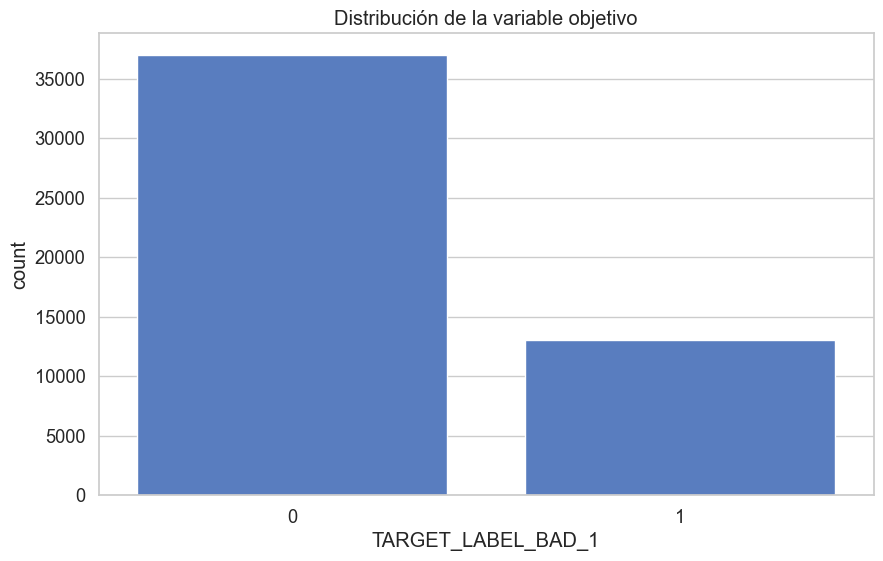

In [326]:
sns.countplot(x="TARGET_LABEL_BAD_1", data=df_train)
plt.title("Distribución de la variable objetivo")
plt.show()

In [327]:
print(df_train["TARGET_LABEL_BAD_1"].value_counts(normalize=True))

TARGET_LABEL_BAD_1
0    0.73918
1    0.26082
Name: proportion, dtype: float64


# 🔢 Correlación con variables númericas

In [328]:
numeric_df = df_train.select_dtypes(include=['int64', 'float64'])
numeric_df.shape

(50000, 34)

In [329]:
correlation_target = numeric_df.corr()['TARGET_LABEL_BAD_1'].sort_values(ascending=False)
print(correlation_target)

TARGET_LABEL_BAD_1                1.000000
PAYMENT_DAY                       0.070633
OCCUPATION_TYPE                   0.040216
PRODUCT                           0.019293
RESIDENCE_TYPE                    0.019168
QUANT_DEPENDANTS                  0.012157
QUANT_SPECIAL_BANKING_ACCOUNTS    0.011997
QUANT_BANKING_ACCOUNTS            0.011997
QUANT_CARS                        0.011706
ID_CLIENT                         0.010509
OTHER_INCOMES                     0.004442
PERSONAL_MONTHLY_INCOME           0.002819
FLAG_DINERS                       0.002240
FLAG_OTHER_CARDS                  0.001410
FLAG_AMERICAN_EXPRESS             0.000337
NACIONALITY                      -0.000952
POSTAL_ADDRESS_TYPE              -0.002423
PERSONAL_ASSETS_VALUE            -0.003886
FLAG_VISA                        -0.005398
MONTHS_IN_THE_JOB                -0.007073
FLAG_EMAIL                       -0.008067
PROFESSION_CODE                  -0.011593
FLAG_MASTERCARD                  -0.017658
MONTHS_IN_R

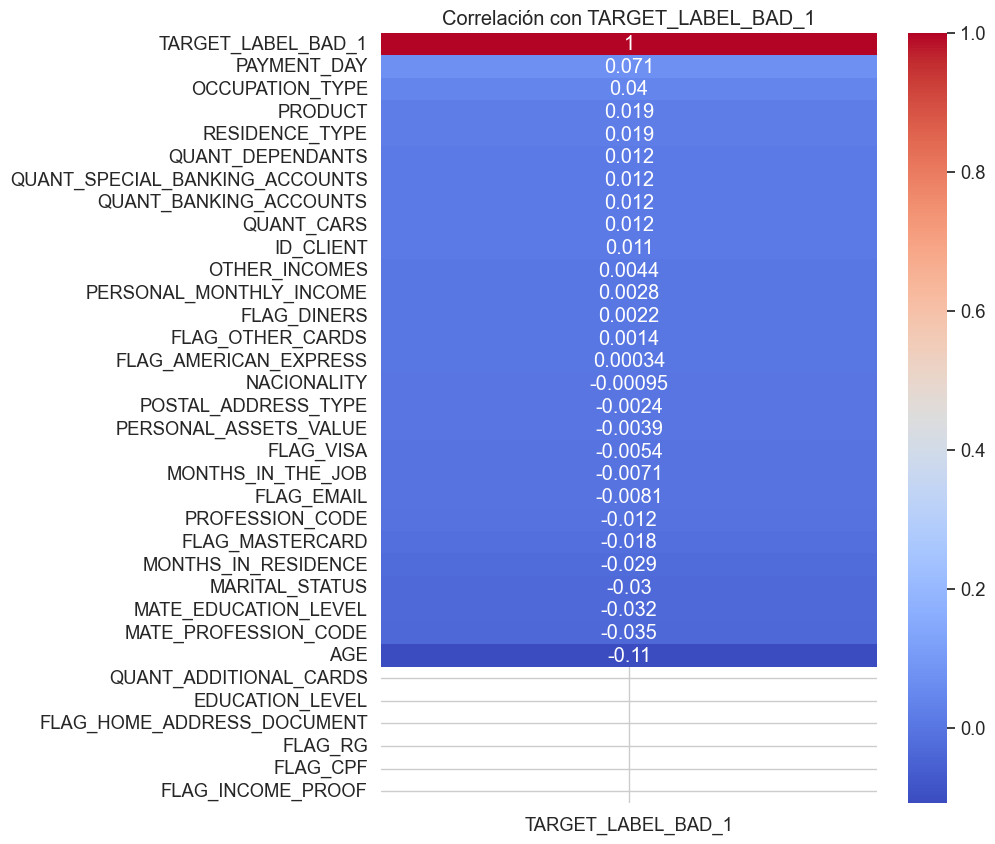

In [330]:
plt.figure(figsize=(8,10))
sns.heatmap(numeric_df.corr()[['TARGET_LABEL_BAD_1']].sort_values(by='TARGET_LABEL_BAD_1', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('Correlación con TARGET_LABEL_BAD_1')
plt.show()

# 🔠 Correlación con variables categoricas

In [331]:
categorical_cols = df_train.select_dtypes(include=['object']).columns
for col in categorical_cols:
    contingency = pd.crosstab(df_train[col], df_train['TARGET_LABEL_BAD_1'])
    chi2, p, dof, ex = chi2_contingency(contingency)
    print(f"{col}: p-value = {p:.4f}")

CLERK_TYPE: p-value = 1.0000
APPLICATION_SUBMISSION_TYPE: p-value = 0.0000
SEX: p-value = 0.0000
STATE_OF_BIRTH: p-value = 0.0000
CITY_OF_BIRTH: p-value = 0.0248
RESIDENCIAL_STATE: p-value = 0.0000
RESIDENCIAL_CITY: p-value = 0.0000
RESIDENCIAL_BOROUGH: p-value = 0.0000
FLAG_RESIDENCIAL_PHONE: p-value = 0.0000
RESIDENCIAL_PHONE_AREA_CODE: p-value = 0.0000
FLAG_MOBILE_PHONE: p-value = 1.0000
COMPANY: p-value = 0.0655
PROFESSIONAL_STATE: p-value = 0.0000
PROFESSIONAL_CITY: p-value = 0.0000
PROFESSIONAL_BOROUGH: p-value = 0.0000
FLAG_PROFESSIONAL_PHONE: p-value = 0.0004
PROFESSIONAL_PHONE_AREA_CODE: p-value = 0.0000
FLAG_ACSP_RECORD: p-value = 1.0000
RESIDENCIAL_ZIP_3: p-value = 0.0000
PROFESSIONAL_ZIP_3: p-value = 0.0000


In [332]:
df_train[categorical_cols].nunique().sort_values(ascending=False)

RESIDENCIAL_BOROUGH             14511
CITY_OF_BIRTH                    9910
PROFESSIONAL_BOROUGH             5057
RESIDENCIAL_CITY                 3529
PROFESSIONAL_CITY                2236
RESIDENCIAL_ZIP_3                 794
PROFESSIONAL_ZIP_3                794
RESIDENCIAL_PHONE_AREA_CODE       102
PROFESSIONAL_PHONE_AREA_CODE       87
STATE_OF_BIRTH                     29
PROFESSIONAL_STATE                 28
RESIDENCIAL_STATE                  27
SEX                                 4
APPLICATION_SUBMISSION_TYPE         3
FLAG_PROFESSIONAL_PHONE             2
FLAG_RESIDENCIAL_PHONE              2
COMPANY                             2
CLERK_TYPE                          1
FLAG_MOBILE_PHONE                   1
FLAG_ACSP_RECORD                    1
dtype: int64

In [333]:
df_train["SEX"].unique()

array(['F', 'M', 'N', ' '], dtype=object)

# 💻 Procesar los datos

In [334]:
# Delete columns with no information (1 category only or 1 numeric value)
drop_cols = ['CLERK_TYPE', 'FLAG_MOBILE_PHONE', 'FLAG_ACSP_RECORD', 'QUANT_ADDITIONAL_CARDS', 'FLAG_HOME_ADDRESS_DOCUMENT', 'FLAG_RG', 'FLAG_CPF', 'FLAG_INCOME_PROOF', 'EDUCATION_LEVEL']
print("Removing columns with no information:", drop_cols)
df_train.drop(columns=drop_cols, inplace=True)

Removing columns with no information: ['CLERK_TYPE', 'FLAG_MOBILE_PHONE', 'FLAG_ACSP_RECORD', 'QUANT_ADDITIONAL_CARDS', 'FLAG_HOME_ADDRESS_DOCUMENT', 'FLAG_RG', 'FLAG_CPF', 'FLAG_INCOME_PROOF', 'EDUCATION_LEVEL']


In [335]:
numeric_real = [
    'AGE',
    'PERSONAL_MONTHLY_INCOME',
    'OTHER_INCOMES',
    'PERSONAL_ASSETS_VALUE',
    'QUANT_CARS',
    'QUANT_DEPENDANTS',
    'QUANT_BANKING_ACCOUNTS',
    'QUANT_SPECIAL_BANKING_ACCOUNTS',
    'MONTHS_IN_THE_JOB',
    'MONTHS_IN_RESIDENCE',
    'PAYMENT_DAY'
]

categorical_encoded = [
    'MARITAL_STATUS',
    'MATE_EDUCATION_LEVEL',
    'RESIDENCE_TYPE',
    'OCCUPATION_TYPE',
    'PRODUCT',
    'POSTAL_ADDRESS_TYPE',
    'PROFESSION_CODE',
    'MATE_PROFESSION_CODE',
    'NACIONALITY'
]

categorical_text = [
    'APPLICATION_SUBMISSION_TYPE',
    'SEX',
    'STATE_OF_BIRTH',
    'CITY_OF_BIRTH',
    'RESIDENCIAL_STATE',
    'RESIDENCIAL_CITY',
    'RESIDENCIAL_BOROUGH',
    'PROFESSIONAL_STATE',
    'PROFESSIONAL_CITY',
    'PROFESSIONAL_BOROUGH',
    'RESIDENCIAL_PHONE_AREA_CODE',
    'PROFESSIONAL_PHONE_AREA_CODE',
    'RESIDENCIAL_ZIP_3',
    'PROFESSIONAL_ZIP_3',
    'COMPANY',
]

flags = [
    'FLAG_RESIDENCIAL_PHONE',
    'FLAG_EMAIL',
    'FLAG_VISA',
    'FLAG_MASTERCARD',
    'FLAG_DINERS',
    'FLAG_AMERICAN_EXPRESS',
    'FLAG_OTHER_CARDS',
    'FLAG_PROFESSIONAL_PHONE',
]

df_train[numeric_real] = df_train[numeric_real].apply(pd.to_numeric, errors='coerce')
df_train[categorical_encoded + categorical_text] = df_train[categorical_encoded + categorical_text].astype('category')
df_train[flags] = (df_train[flags].replace({'Y': 1, 'N': 0}).astype('Int64'))

C:\Users\Usuario\AppData\Local\Temp\ipykernel_6868\3181428814.py:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train[flags] = (df_train[flags].replace({'Y': 1, 'N': 0}).astype('Int64'))


In [336]:
# Impute missing values
categorical_cols_to_impute = ['PROFESSION_CODE', 'OCCUPATION_TYPE', 'RESIDENCE_TYPE']
for col in categorical_cols_to_impute:
    df_train[col] = df_train[col].fillna(df_train[col].mode()[0])

df_train['MONTHS_IN_RESIDENCE'] = df_train['MONTHS_IN_RESIDENCE'].fillna(df_train['MONTHS_IN_RESIDENCE'].mean())

# Verify imputation
print(df_train[['PROFESSION_CODE', 'OCCUPATION_TYPE', 'RESIDENCE_TYPE', 'MONTHS_IN_RESIDENCE']].isnull().sum())

PROFESSION_CODE        0
OCCUPATION_TYPE        0
RESIDENCE_TYPE         0
MONTHS_IN_RESIDENCE    0
dtype: int64


In [337]:
numeric_df = df_train.select_dtypes(include=['int64', 'float64'])
numeric_df.shape

(50000, 21)

In [338]:
corr = numeric_df.corrwith(df_train['TARGET_LABEL_BAD_1'])
print(corr.sort_values(ascending=False))

TARGET_LABEL_BAD_1                1.000000
PAYMENT_DAY                       0.070633
FLAG_PROFESSIONAL_PHONE           0.015859
QUANT_DEPENDANTS                  0.012157
QUANT_SPECIAL_BANKING_ACCOUNTS    0.011997
QUANT_BANKING_ACCOUNTS            0.011997
QUANT_CARS                        0.011706
ID_CLIENT                         0.010509
OTHER_INCOMES                     0.004442
PERSONAL_MONTHLY_INCOME           0.002819
FLAG_DINERS                       0.002240
FLAG_OTHER_CARDS                  0.001410
FLAG_AMERICAN_EXPRESS             0.000337
PERSONAL_ASSETS_VALUE            -0.003886
FLAG_VISA                        -0.005398
MONTHS_IN_THE_JOB                -0.007073
FLAG_EMAIL                       -0.008067
FLAG_MASTERCARD                  -0.017658
MONTHS_IN_RESIDENCE              -0.028241
FLAG_RESIDENCIAL_PHONE           -0.060750
AGE                              -0.107886
dtype: float64


In [339]:
categorical_cols = df_train.select_dtypes(include=['category']).columns

for col in categorical_cols:
    if df_train[col].nunique() > 1:
        table = pd.crosstab(df_train[col], df_train['TARGET_LABEL_BAD_1'])
        chi2, p, dof, exp = chi2_contingency(table)
        print(f"{col}: p-value = {p:.4f}")

APPLICATION_SUBMISSION_TYPE: p-value = 0.0000
POSTAL_ADDRESS_TYPE: p-value = 0.6322
SEX: p-value = 0.0000
MARITAL_STATUS: p-value = 0.0000
STATE_OF_BIRTH: p-value = 0.0000
CITY_OF_BIRTH: p-value = 0.0248
NACIONALITY: p-value = 0.9661
RESIDENCIAL_STATE: p-value = 0.0000
RESIDENCIAL_CITY: p-value = 0.0000
RESIDENCIAL_BOROUGH: p-value = 0.0000
RESIDENCIAL_PHONE_AREA_CODE: p-value = 0.0000
RESIDENCE_TYPE: p-value = 0.0000
COMPANY: p-value = 0.0655
PROFESSIONAL_STATE: p-value = 0.0000
PROFESSIONAL_CITY: p-value = 0.0000
PROFESSIONAL_BOROUGH: p-value = 0.0000
PROFESSIONAL_PHONE_AREA_CODE: p-value = 0.0000
PROFESSION_CODE: p-value = 0.0000
OCCUPATION_TYPE: p-value = 0.0000
MATE_PROFESSION_CODE: p-value = 0.0001
MATE_EDUCATION_LEVEL: p-value = 0.0000
PRODUCT: p-value = 0.0000
RESIDENCIAL_ZIP_3: p-value = 0.0000
PROFESSIONAL_ZIP_3: p-value = 0.0000


In [340]:
df_train[categorical_encoded + categorical_text].nunique().sort_values(ascending=False)

RESIDENCIAL_BOROUGH             14511
CITY_OF_BIRTH                    9910
PROFESSIONAL_BOROUGH             5057
RESIDENCIAL_CITY                 3529
PROFESSIONAL_CITY                2236
PROFESSIONAL_ZIP_3                794
RESIDENCIAL_ZIP_3                 794
RESIDENCIAL_PHONE_AREA_CODE       102
PROFESSIONAL_PHONE_AREA_CODE       87
STATE_OF_BIRTH                     29
PROFESSIONAL_STATE                 28
RESIDENCIAL_STATE                  27
PROFESSION_CODE                    19
MATE_PROFESSION_CODE               18
MARITAL_STATUS                      8
MATE_EDUCATION_LEVEL                6
RESIDENCE_TYPE                      6
OCCUPATION_TYPE                     6
SEX                                 4
PRODUCT                             3
APPLICATION_SUBMISSION_TYPE         3
NACIONALITY                         3
POSTAL_ADDRESS_TYPE                 2
COMPANY                             2
dtype: int64

In [341]:
# Delete columns with high percentage of missing values
high_missing_cols = null_summary[null_summary['Missing_Percent'] > 50].index.tolist()
print("Removing columns with more than 50% missing values:", high_missing_cols)
df_train.drop(columns=high_missing_cols, inplace=True)

Removing columns with more than 50% missing values: ['PROFESSIONAL_BOROUGH', 'PROFESSIONAL_CITY', 'MATE_EDUCATION_LEVEL', 'MATE_PROFESSION_CODE']


In [342]:
# Delete columns with high cardinality
categorical_cols = df_train.select_dtypes(include=['category']).columns

high_cardinality_cols = df_train[categorical_cols].nunique()
high_cardinality_cols = high_cardinality_cols[high_cardinality_cols > 500].index.tolist()
print("Removing columns with high cardinality:", high_cardinality_cols)
df_train.drop(columns=high_cardinality_cols, inplace=True)


Removing columns with high cardinality: ['CITY_OF_BIRTH', 'RESIDENCIAL_CITY', 'RESIDENCIAL_BOROUGH', 'RESIDENCIAL_ZIP_3', 'PROFESSIONAL_ZIP_3']


In [343]:
# Delete columns with high p-value (low correlation with target)
cols_to_check = df_train.select_dtypes(include=['category']).columns
for col in cols_to_check:
    if df_train[col].nunique() > 1:
        table = pd.crosstab(df_train[col], df_train['TARGET_LABEL_BAD_1'])
        chi2, p, dof, exp = chi2_contingency(table)
        if p > 0.05:
            print(f"Removing column {col} with p-value = {p:.4f}")
            df_train.drop(columns=[col], inplace=True)

Removing column POSTAL_ADDRESS_TYPE with p-value = 0.6322
Removing column NACIONALITY with p-value = 0.9661
Removing column COMPANY with p-value = 0.0655


In [344]:
# Delete columns wit low correlation with target
min_correlation = 0.05
max_correlation = 0.99

always_exclude = ['ID_CLIENT', 'TARGET_LABEL_BAD_1']

corr_abs = corr.abs()

cols_to_keep = corr_abs[
    (corr_abs >= min_correlation) & 
    (corr_abs <= max_correlation) & 
    (~corr_abs.index.isin(always_exclude))
].index.tolist()

cols_to_drop = [col for col in numeric_df.columns if col not in cols_to_keep and col not in always_exclude]

print(f"Columnas a mantener ({len(cols_to_keep)}): {cols_to_keep}")
print(f"\nColumnas a descartar ({len(cols_to_drop)}): {cols_to_drop}")

df_train = df_train.drop(columns=cols_to_drop, errors='ignore')

Columnas a mantener (3): ['PAYMENT_DAY', 'FLAG_RESIDENCIAL_PHONE', 'AGE']

Columnas a descartar (16): ['QUANT_DEPENDANTS', 'MONTHS_IN_RESIDENCE', 'FLAG_EMAIL', 'PERSONAL_MONTHLY_INCOME', 'OTHER_INCOMES', 'FLAG_VISA', 'FLAG_MASTERCARD', 'FLAG_DINERS', 'FLAG_AMERICAN_EXPRESS', 'FLAG_OTHER_CARDS', 'QUANT_BANKING_ACCOUNTS', 'QUANT_SPECIAL_BANKING_ACCOUNTS', 'PERSONAL_ASSETS_VALUE', 'QUANT_CARS', 'FLAG_PROFESSIONAL_PHONE', 'MONTHS_IN_THE_JOB']


In [345]:
df_train['SEX'] = df_train['SEX'].str.strip()
df_train['SEX'] = df_train['SEX'].replace('M', 'MALE')
df_train['SEX'] = df_train['SEX'].replace('F', 'FEMALE')
df_train['SEX'] = df_train['SEX'].replace('N', 'OTHER')
df_train['SEX'] = df_train['SEX'].replace('', 'OTHER')
df_train['SEX'].value_counts()

SEX
FEMALE    30805
MALE      19130
OTHER        65
Name: count, dtype: int64

In [346]:
df_train.shape

(50000, 17)

In [347]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   ID_CLIENT                     50000 non-null  int64   
 1   PAYMENT_DAY                   50000 non-null  int64   
 2   APPLICATION_SUBMISSION_TYPE   50000 non-null  category
 3   SEX                           50000 non-null  object  
 4   MARITAL_STATUS                50000 non-null  category
 5   STATE_OF_BIRTH                50000 non-null  category
 6   RESIDENCIAL_STATE             50000 non-null  category
 7   FLAG_RESIDENCIAL_PHONE        50000 non-null  Int64   
 8   RESIDENCIAL_PHONE_AREA_CODE   50000 non-null  category
 9   RESIDENCE_TYPE                50000 non-null  category
 10  PROFESSIONAL_STATE            50000 non-null  category
 11  PROFESSIONAL_PHONE_AREA_CODE  50000 non-null  category
 12  PROFESSION_CODE               50000 non-null  

In [348]:
categorical_cols = df_train.select_dtypes(include=['category']).columns

for col in categorical_cols:
    if df_train[col].nunique() > 1:
        table = pd.crosstab(df_train[col], df_train['TARGET_LABEL_BAD_1'])
        chi2, p, dof, exp = chi2_contingency(table)
        print(f"{col}: p-value = {p:.8f}")

APPLICATION_SUBMISSION_TYPE: p-value = 0.00000653
MARITAL_STATUS: p-value = 0.00000000
STATE_OF_BIRTH: p-value = 0.00000000
RESIDENCIAL_STATE: p-value = 0.00000000
RESIDENCIAL_PHONE_AREA_CODE: p-value = 0.00000000
RESIDENCE_TYPE: p-value = 0.00000001
PROFESSIONAL_STATE: p-value = 0.00000000
PROFESSIONAL_PHONE_AREA_CODE: p-value = 0.00000000
PROFESSION_CODE: p-value = 0.00000005
OCCUPATION_TYPE: p-value = 0.00000000
PRODUCT: p-value = 0.00002943


In [349]:
numeric_df = df_train.select_dtypes(include=['int64', 'float64'])
correlation_target = numeric_df.corr()['TARGET_LABEL_BAD_1'].sort_values(ascending=False)
print(correlation_target)

TARGET_LABEL_BAD_1        1.000000
PAYMENT_DAY               0.070633
ID_CLIENT                 0.010509
FLAG_RESIDENCIAL_PHONE   -0.060750
AGE                      -0.107886
Name: TARGET_LABEL_BAD_1, dtype: float64


In [350]:
df_train['MIGRATED'] = (
    df_train['STATE_OF_BIRTH'].astype(str) != df_train['RESIDENCIAL_STATE'].astype(str)
).astype(int)

# 1.2 Feature: Consistencia residencial-profesional
df_train['SAME_RES_PROF_STATE'] = (
    df_train['RESIDENCIAL_STATE'].astype(str) == df_train['PROFESSIONAL_STATE'].astype(str)
).astype(int)

# 1.3 Feature: Consistencia área telefónica
df_train['SAME_PHONE_AREA'] = (
    df_train['RESIDENCIAL_PHONE_AREA_CODE'].astype(str) == 
    df_train['PROFESSIONAL_PHONE_AREA_CODE'].astype(str)
).astype(int)

# 1.4 Binning de edad (grupos más específicos)
df_train['AGE_GROUP'] = pd.cut(
    df_train['AGE'], 
    bins=[0, 25, 30, 35, 40, 50, 100], 
    labels=['18-25', '26-30', '31-35', '36-40', '41-50', '51+']
)

# 1.5 Binning de payment day
df_train['PAYMENT_PERIOD'] = pd.cut(
    df_train['PAYMENT_DAY'], 
    bins=[0, 5, 15, 25, 31], 
    labels=['Early', 'Mid-Early', 'Mid-Late', 'Late']
)

# 1.6 Interacciones clave
df_train['AGE_MARITAL'] = (
    df_train['AGE_GROUP'].astype(str) + '_' + 
    df_train['MARITAL_STATUS'].astype(str)
)

df_train['RESIDENCE_PRODUCT'] = (
    df_train['RESIDENCE_TYPE'].astype(str) + '_' + 
    df_train['PRODUCT'].astype(str)
)

In [351]:
cols_to_drop = ['ID_CLIENT', 'STATE_OF_BIRTH', 'PAYMENT_DAY', 'AGE']
X = df_train.drop(columns=cols_to_drop + ['TARGET_LABEL_BAD_1'])
y = df_train['TARGET_LABEL_BAD_1']

# Variables nominales (One-Hot Encoding)
nominal_cols = [
    'SEX', 'APPLICATION_SUBMISSION_TYPE', 'PRODUCT', 
    'AGE_GROUP', 'PAYMENT_PERIOD', 'MARITAL_STATUS',
    'RESIDENCE_TYPE', 'OCCUPATION_TYPE'
]

# Variables de alta cardinalidad (Label Encoding)
high_card_cols = [
    'RESIDENCIAL_STATE', 'PROFESSIONAL_STATE',
    'RESIDENCIAL_PHONE_AREA_CODE', 'PROFESSIONAL_PHONE_AREA_CODE',
    'PROFESSION_CODE', 'AGE_MARITAL', 'RESIDENCE_PRODUCT'
]

# One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=nominal_cols, drop_first=True)

# Label Encoding para alta cardinalidad
label_encoders = {}
for col in high_card_cols:
    if col in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        label_encoders[col] = le

# Convertir todo a float64
X_encoded = X_encoded.astype('float64')

In [352]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Scaling (importante para regresión logística)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir de vuelta a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


In [353]:
# Estrategia 1: SMOTE moderado
smote_moderate = SMOTE(sampling_strategy=0.6, random_state=42)
X_train_smote_mod, y_train_smote_mod = smote_moderate.fit_resample(X_train_scaled, y_train)

# Estrategia 2: SMOTE agresivo
smote_aggressive = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_smote_agg, y_train_smote_agg = smote_aggressive.fit_resample(X_train_scaled, y_train)

# Estrategia 3: SMOTE + Undersampling
pipeline_balanced = ImbPipeline([
    ('over', SMOTE(sampling_strategy=0.8, random_state=42)),
    ('under', RandomUnderSampler(sampling_strategy=0.9, random_state=42))
])
X_train_balanced, y_train_balanced = pipeline_balanced.fit_resample(X_train_scaled, y_train)

print(f"Distribución original:")
print(y_train.value_counts(normalize=True))
print(f"\nDistribución SMOTE moderado (0.6):")
print(pd.Series(y_train_smote_mod).value_counts(normalize=True))
print(f"\nDistribución SMOTE agresivo (1.0):")
print(pd.Series(y_train_smote_agg).value_counts(normalize=True))
print(f"\nDistribución SMOTE + Undersampling:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))

Distribución original:
TARGET_LABEL_BAD_1
0    0.739175
1    0.260825
Name: proportion, dtype: float64

Distribución SMOTE moderado (0.6):
TARGET_LABEL_BAD_1
0    0.625003
1    0.374997
Name: proportion, dtype: float64

Distribución SMOTE agresivo (1.0):
TARGET_LABEL_BAD_1
0    0.5
1    0.5
Name: proportion, dtype: float64

Distribución SMOTE + Undersampling:
TARGET_LABEL_BAD_1
0    0.526315
1    0.473685
Name: proportion, dtype: float64


In [354]:
configs = {
    'Sin balanceo': (X_train_scaled, y_train),
    'SMOTE moderado': (X_train_smote_mod, y_train_smote_mod),
    'SMOTE agresivo': (X_train_smote_agg, y_train_smote_agg),
    'SMOTE + Undersample': (X_train_balanced, y_train_balanced),
}

# Diferentes hiperparámetros
param_configs = [
    {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': None},
    {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': None},
    {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': None},
    {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None},
    {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced'},
]

results_all = []

for config_name, (X_tr, y_tr) in configs.items():
    print(f"\n{config_name}:")
    for idx, params in enumerate(param_configs):
        model = LogisticRegression(max_iter=1000, random_state=42, **params)
        model.fit(X_tr, y_tr)
        
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        results_all.append({
            'Config': config_name,
            'Params': f"C={params['C']}, penalty={params['penalty']}, cw={params['class_weight']}",
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
            'Model': model
        })
        print(f"  [{idx+1}] C={params['C']}, {params['penalty']}: "
              f"ROC-AUC={results_all[-1]['ROC-AUC']:.4f}, "
              f"F1={results_all[-1]['F1-Score']:.4f}")



Sin balanceo:
  [1] C=1.0, l2: ROC-AUC=0.6132, F1=0.0068
  [2] C=0.1, l2: ROC-AUC=0.6132, F1=0.0068
  [3] C=0.01, l2: ROC-AUC=0.6134, F1=0.0061
  [4] C=1.0, l1: ROC-AUC=0.6132, F1=0.0068
  [5] C=1.0, l2: ROC-AUC=0.6133, F1=0.4214

SMOTE moderado:
  [1] C=1.0, l2: ROC-AUC=0.6134, F1=0.2106
  [2] C=0.1, l2: ROC-AUC=0.6134, F1=0.2102
  [3] C=0.01, l2: ROC-AUC=0.6138, F1=0.2115
  [4] C=1.0, l1: ROC-AUC=0.6134, F1=0.2102
  [5] C=1.0, l2: ROC-AUC=0.6135, F1=0.4250

SMOTE agresivo:
  [1] C=1.0, l2: ROC-AUC=0.6141, F1=0.4245
  [2] C=0.1, l2: ROC-AUC=0.6141, F1=0.4248
  [3] C=0.01, l2: ROC-AUC=0.6142, F1=0.4252
  [4] C=1.0, l1: ROC-AUC=0.6141, F1=0.4249
  [5] C=1.0, l2: ROC-AUC=0.6141, F1=0.4245

SMOTE + Undersample:
  [1] C=1.0, l2: ROC-AUC=0.6137, F1=0.4011
  [2] C=0.1, l2: ROC-AUC=0.6137, F1=0.4017
  [3] C=0.01, l2: ROC-AUC=0.6140, F1=0.4019
  [4] C=1.0, l1: ROC-AUC=0.6137, F1=0.4018
  [5] C=1.0, l2: ROC-AUC=0.6137, F1=0.4254


In [355]:
results_df = pd.DataFrame(results_all)
results_df_display = results_df.drop(columns=['Model'])

# Top 10 por ROC-AUC
print("\nTOP 10 MODELOS POR ROC-AUC:")
print(results_df_display.nlargest(10, 'ROC-AUC').to_string(index=False))

# Top 10 por F1-Score
print("\n\nTOP 10 MODELOS POR F1-SCORE:")
print(results_df_display.nlargest(10, 'F1-Score').to_string(index=False))

# Seleccionar el mejor modelo por F1-Score (balance entre precision y recall)
best_idx = results_df['F1-Score'].idxmax()
best_config = results_df.loc[best_idx]
best_model = best_config['Model']

print("\n" + "=" * 70)
print("MEJOR MODELO SELECCIONADO (F1-Score)")
print("=" * 70)
print(f"Configuración: {best_config['Config']}")
print(f"Parámetros: {best_config['Params']}")
print(f"Accuracy:  {best_config['Accuracy']:.4f}")
print(f"Precision: {best_config['Precision']:.4f}")
print(f"Recall:    {best_config['Recall']:.4f}")
print(f"F1-Score:  {best_config['F1-Score']:.4f}")
print(f"ROC-AUC:   {best_config['ROC-AUC']:.4f}")



TOP 10 MODELOS POR ROC-AUC:
             Config                         Params  Accuracy  Precision   Recall  F1-Score  ROC-AUC
     SMOTE agresivo    C=0.01, penalty=l2, cw=None    0.5710   0.326812 0.608512  0.425241 0.614199
     SMOTE agresivo     C=1.0, penalty=l1, cw=None    0.5710   0.326669 0.607745  0.424933 0.614108
     SMOTE agresivo     C=1.0, penalty=l2, cw=None    0.5710   0.326455 0.606595  0.424470 0.614103
     SMOTE agresivo C=1.0, penalty=l2, cw=balanced    0.5710   0.326455 0.606595  0.424470 0.614103
     SMOTE agresivo     C=0.1, penalty=l2, cw=None    0.5710   0.326598 0.607362  0.424779 0.614098
SMOTE + Undersample    C=0.01, penalty=l2, cw=None    0.6149   0.337771 0.496166  0.401926 0.614043
     SMOTE moderado    C=0.01, penalty=l2, cw=None    0.7174   0.388320 0.145322  0.211496 0.613761
SMOTE + Undersample     C=0.1, penalty=l2, cw=None    0.6152   0.337866 0.495399  0.401741 0.613730
SMOTE + Undersample C=1.0, penalty=l2, cw=balanced    0.5704   0.326623


RESULTADOS POR THRESHOLD:
 Threshold  Accuracy  Precision   Recall  F1-Score
      0.20    0.2609   0.260826 1.000000  0.413738
      0.25    0.2638   0.261489 0.999233  0.414506
      0.30    0.2910   0.266805 0.983129  0.419709
      0.35    0.3549   0.280124 0.938650  0.431480
      0.40    0.4183   0.292566 0.867715  0.437591
      0.45    0.4882   0.308163 0.773006  0.440656
      0.50    0.5704   0.326623 0.609663  0.425361
      0.55    0.6428   0.340397 0.394172  0.365316

✓ Threshold óptimo: 0.45

EVALUACIÓN FINAL - THRESHOLD 0.45
              precision    recall  f1-score   support

        GOOD       0.83      0.39      0.53      7392
         BAD       0.31      0.77      0.44      2608

    accuracy                           0.49     10000
   macro avg       0.57      0.58      0.48     10000
weighted avg       0.69      0.49      0.51     10000



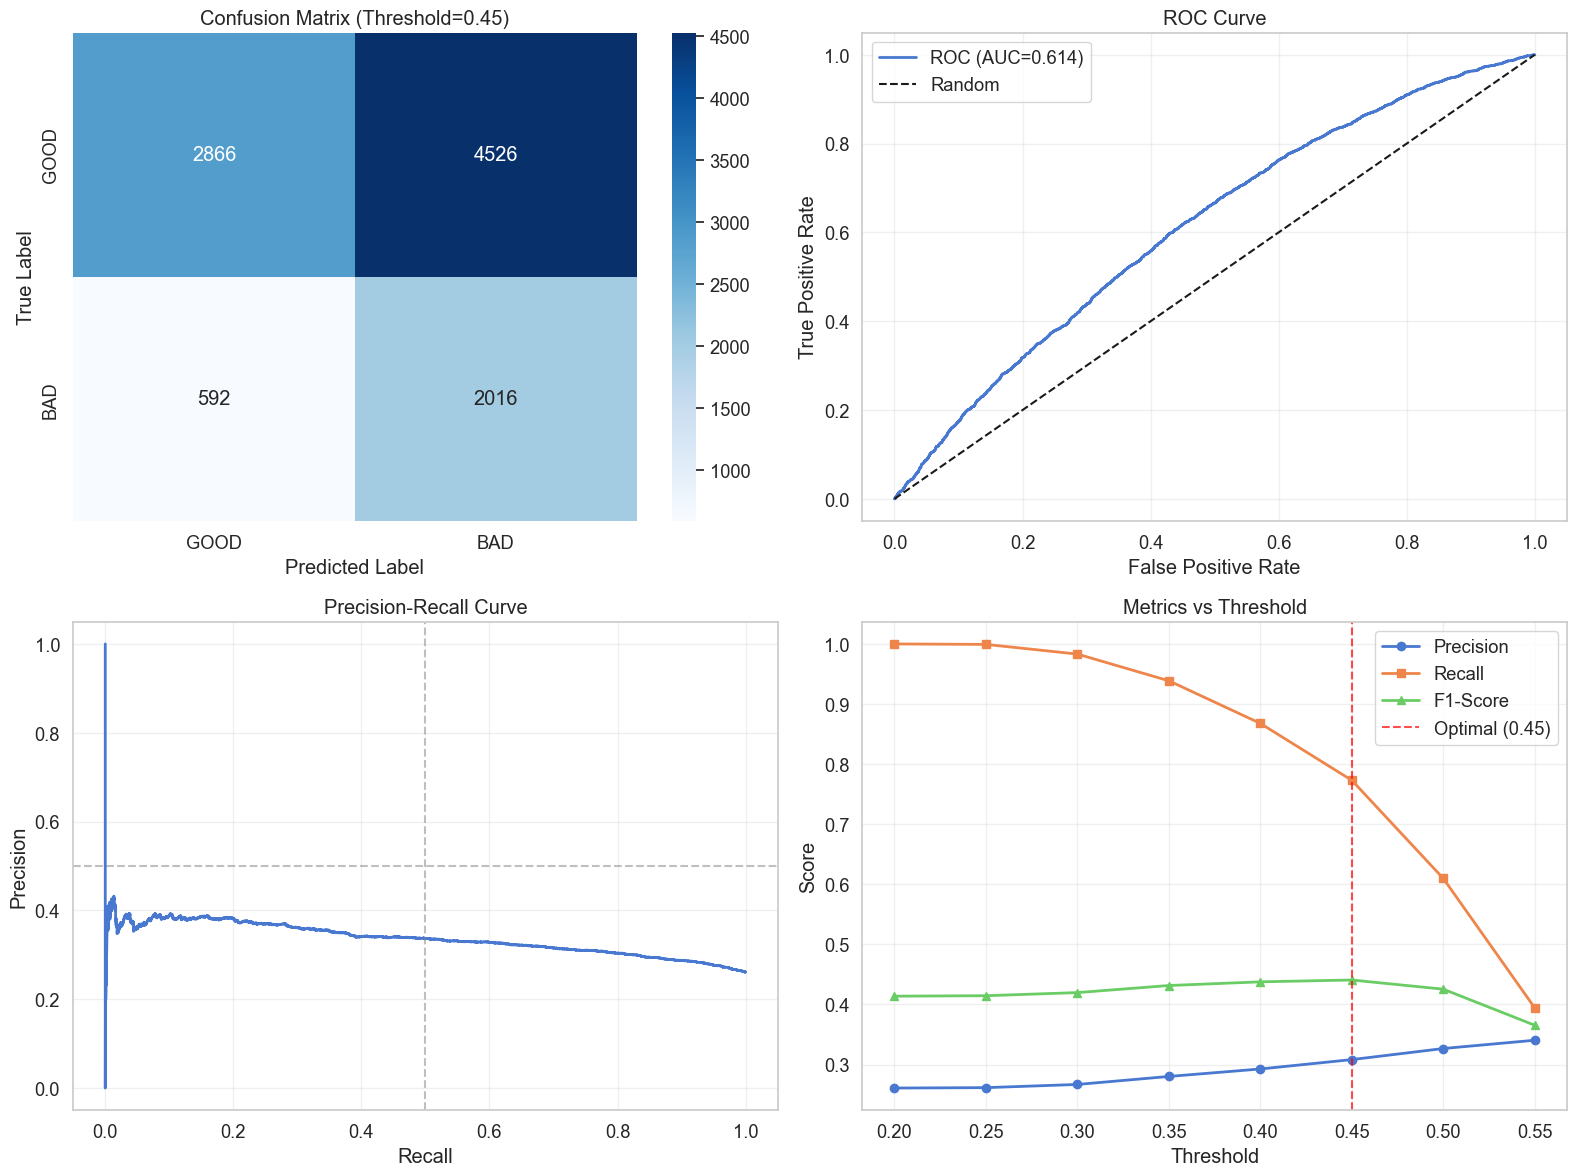

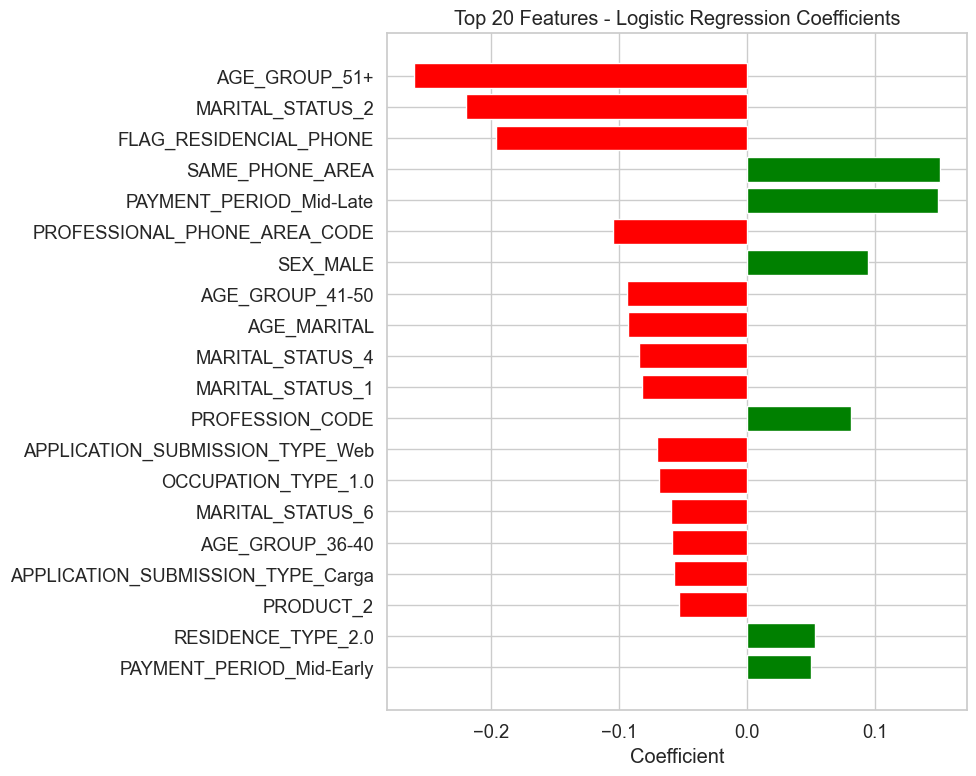

In [356]:
y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

# Probar diferentes thresholds
thresholds_test = np.arange(0.2, 0.6, 0.05)
threshold_results = []

for thresh in thresholds_test:
    y_pred_thresh = (y_pred_proba_best >= thresh).astype(int)
    
    threshold_results.append({
        'Threshold': thresh,
        'Accuracy': accuracy_score(y_test, y_pred_thresh),
        'Precision': precision_score(y_test, y_pred_thresh),
        'Recall': recall_score(y_test, y_pred_thresh),
        'F1-Score': f1_score(y_test, y_pred_thresh)
    })

threshold_df = pd.DataFrame(threshold_results)
print("\nRESULTADOS POR THRESHOLD:")
print(threshold_df.to_string(index=False))

# Seleccionar mejor threshold
best_threshold = threshold_df.loc[threshold_df['F1-Score'].idxmax(), 'Threshold']
print(f"\n✓ Threshold óptimo: {best_threshold:.2f}")

# ============================================================
# PASO 8: EVALUACIÓN FINAL
# ============================================================
print("\n" + "=" * 70)
print(f"EVALUACIÓN FINAL - THRESHOLD {best_threshold:.2f}")
print("=" * 70)

y_pred_final = (y_pred_proba_best >= best_threshold).astype(int)

print(classification_report(y_test, y_pred_final, target_names=['GOOD', 'BAD']))

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['GOOD', 'BAD'], 
            yticklabels=['GOOD', 'BAD'],
            ax=axes[0, 0])
axes[0, 0].set_title(f'Confusion Matrix (Threshold={best_threshold:.2f})')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC={best_config["ROC-AUC"]:.3f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Precision-Recall Curve
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_best)
axes[1, 0].plot(recalls, precisions, linewidth=2)
axes[1, 0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve')
axes[1, 0].grid(alpha=0.3)

# 4. Threshold Impact
axes[1, 1].plot(threshold_df['Threshold'], threshold_df['Precision'], 
                label='Precision', linewidth=2, marker='o')
axes[1, 1].plot(threshold_df['Threshold'], threshold_df['Recall'], 
                label='Recall', linewidth=2, marker='s')
axes[1, 1].plot(threshold_df['Threshold'], threshold_df['F1-Score'], 
                label='F1-Score', linewidth=2, marker='^')
axes[1, 1].axvline(x=best_threshold, color='red', linestyle='--', 
                   alpha=0.7, label=f'Optimal ({best_threshold:.2f})')
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Metrics vs Threshold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance (coeficientes)
coefficients = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient': best_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False).head(20)

plt.figure(figsize=(10, 8))
colors = ['red' if x < 0 else 'green' for x in coefficients['Coefficient']]
plt.barh(coefficients['Feature'], coefficients['Coefficient'], color=colors)
plt.xlabel('Coefficient')
plt.title('Top 20 Features - Logistic Regression Coefficients')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
